<a href="https://colab.research.google.com/github/eshnil2000/google-colab/blob/master/visualizing-what-convnets-learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
import warnings
warnings.simplefilter('ignore')

!pip install sklearn matplotlib tensorflow keras pandas numpy
import keras
!git clone https://github.com/eshnil2000/google-colab.git
from keras import models
import tensorflow as tf
%cd google-colab;
keras.__version__;

In [25]:
from keras.models import load_model

model = load_model('models/cats_and_dogs_small_2.h5')
model.summary()  # As a reminder.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 15, 15, 128)       147584    
__________

This will be the input image we will use -- a picture of a cat, not part of images that the network was trained on:

In [26]:
img_path = 'images/cat.png'

# We preprocess the image into a 4D tensor
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

(1, 150, 150, 3)


Let's display our picture:

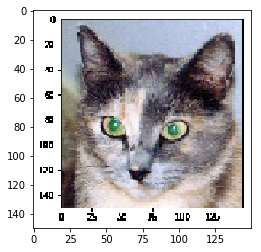

In [27]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [0]:
from keras import models

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

When fed an image input, this model returns the values of the layer activations in the original model. This is the first time you encounter 
a multi-output model in this book: until now the models you have seen only had exactly one input and one output. In the general case, a 
model could have any number of inputs and outputs. This one has one input and 8 outputs, one output per layer activation.

In [0]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)

For instance, this is the activation of the first convolution layer for our cat image input:

In [30]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


It's a 148x148 feature map with 32 channels. Let's try visualizing the 3rd channel:

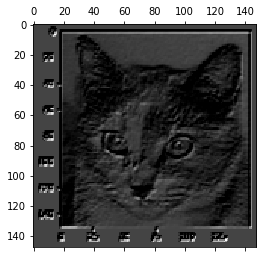

In [31]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 0], cmap='gray')
plt.show()

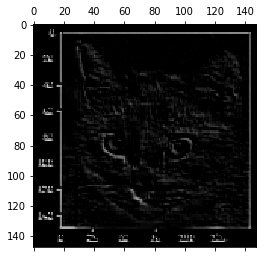

In [32]:
plt.matshow(first_layer_activation[0, :, :, 15], cmap='gray')
plt.show()

This one looks like a "bright green dot" detector, useful to encode cat eyes. At this point, let's go and plot a complete visualization of 
all the activations in the network. We'll extract and plot every channel in each of our 8 activation maps, and we will stack the results in 
one big image tensor, with channels stacked side by side.

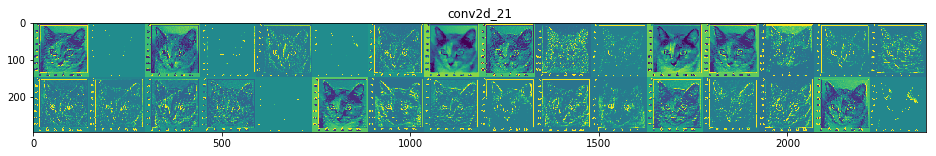

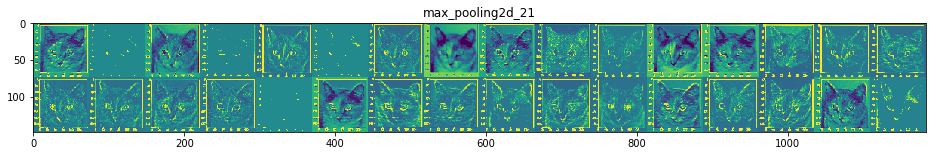

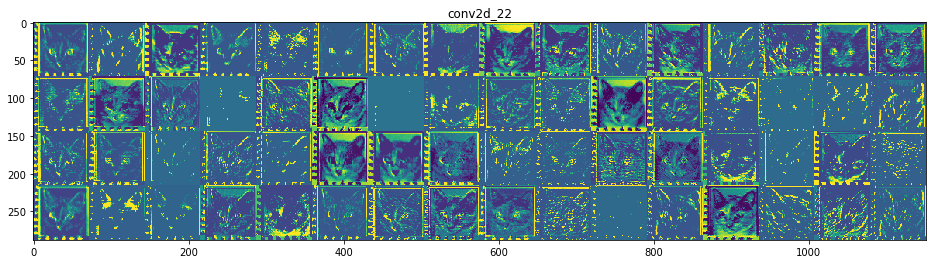

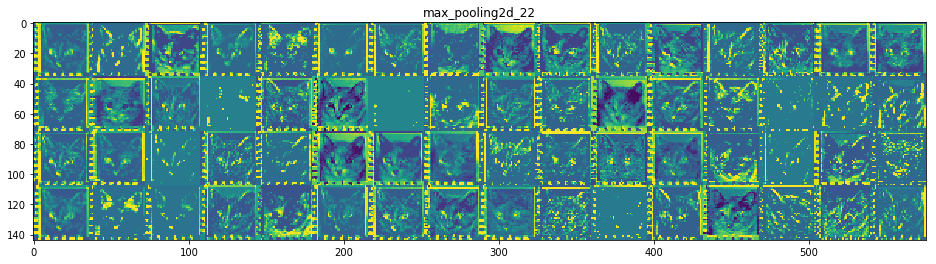

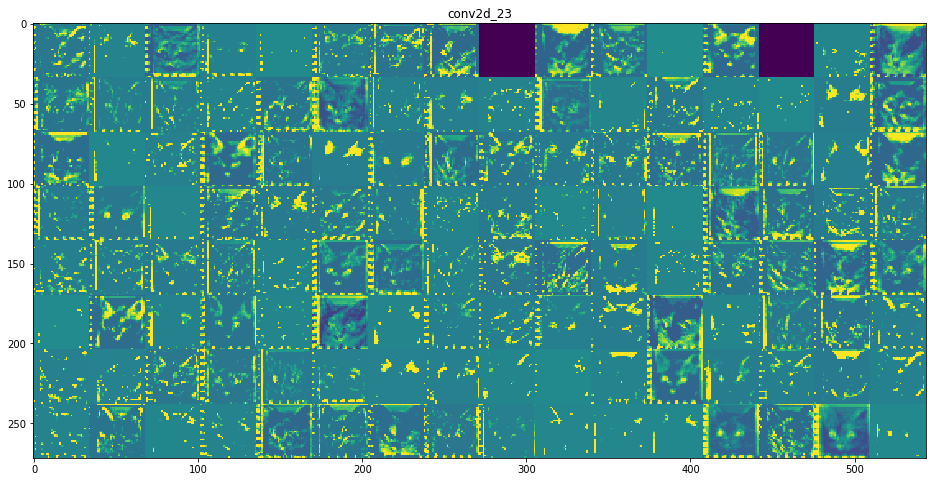

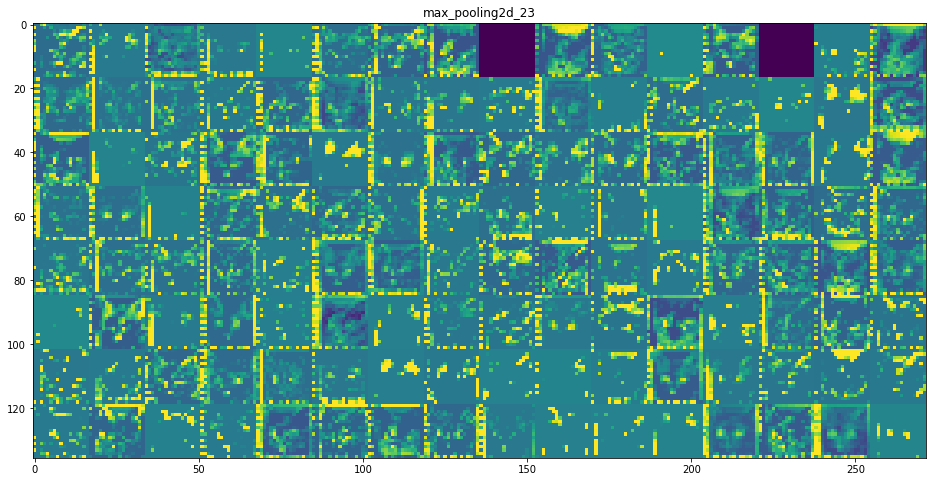

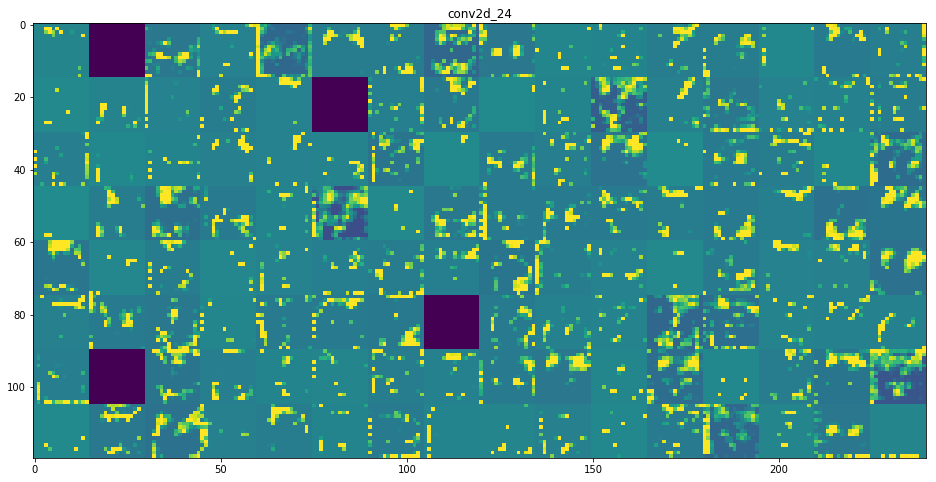

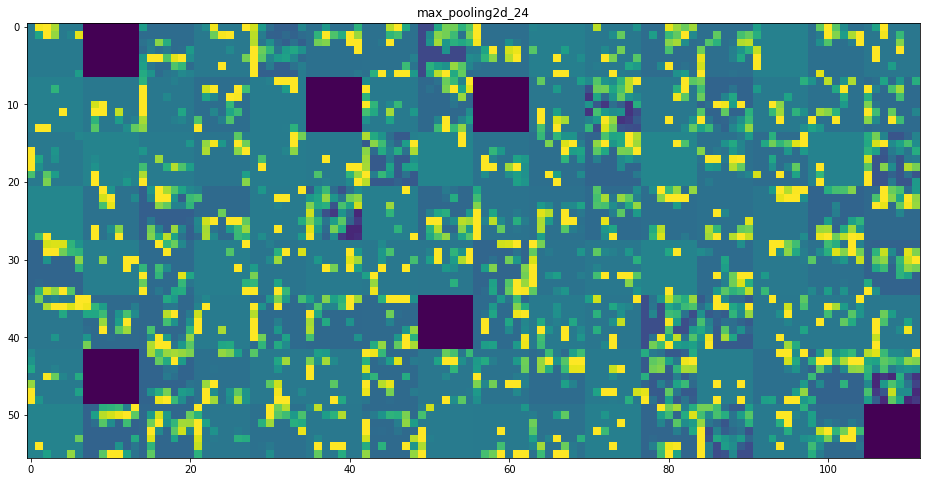

In [33]:
import keras

# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()